## Лабораторная работа №5 
###  По предмету "методы, средства и технологии мультимедиа"
#### Выполнил: Пивницкий Д.С. 
#### Группа: М8о-406Б-19

In [40]:
import os
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для создания лейблов использовался следующий код:

In [ ]:
from PIL import Image
import csv

imh = 720
imw = 1280

with open('train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')    
    cnt = 0
    for row in spamreader:
        
        if(row[0] == '0'):
            cnt += 1
            rd = row[5]
            num = ''
            totext = ''            
            pst = ''
            wrt_n = 0
            for lit in rd:                
                if(lit in ['0','1','2','3','4','5','6','7','8','9']):
                    num += lit
                else:
                    if(num != ''):
                        if(wrt_n == 0):
                            totext += '0 '
                        wrt_n += 1
                        
                        if(wrt_n % 2 == 1):
                            num = str(int(num) / imw)
                        else:
                            num = str(int(num) / imh)                            
                        totext += num + ' '                                              
                    num = ''                
                if(lit == ',' and pst == '}'):                     
                    totext += '\n' 
                    wrt_n = 0                
                pst = lit
            print(totext)
            with open('labels/train/' + row[2] + '.txt', 'w') as f:
                f.write(totext)           
            with Image.open('images/train/' + row[2] + '.jpg') as im:
                im2 = im.resize([int(imw/2),int(imh/2)])
                im2.save('images/train/' + row[2] + '.jpg', "JPEG")            
    print(cnt)

In [41]:
#!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.5/78.2 GB disk)


Так как полноразмерные изображения очень долго грузились на гугл диск, я уменьшил разрешение до 640х360.  
Также из датасета были удалены изображения, на которых не было морских звезд. Для этого использовалася следующий код:

In [18]:
for name in tqdm(os.listdir('labels/train')):
    to_rm = False
    with open('labels/train/' + name, 'r') as f:
        fcon = f.read()
        if(fcon == ''):
            to_rm = True
            #print("removing " + name[: -4])
    if(to_rm):
        os.remove('labels/train/' + name)
        os.remove('images/train/' + name[: -4] + '.jpg')

100%|██████████| 6687/6687 [00:26<00:00, 248.35it/s]


После этого в датасете осталось 2143 изображения, которые были разлены на обучающую и тестовую выборку соответственно.   
Обучающая выборка содержит 1712 изображений, а тестовая 431.

Для передачи датасета модели был создан yaml файл со следующим содержанием:

train: ../../datasets/reef2/images/train  
val: ../../datasets/reef2/images/val

nc: 1
names: ['starfish']

##### Процесс обучения:

In [43]:
!python3 train.py --img 640 --batch 16 --epochs 20 --data /content/drive/MyDrive/datasets/reef2/reef.yaml --weights yolov5s.pt --device 0 --hyp data/hyps/hyp.scratch-low.yaml


train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/datasets/reef2/reef.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw

В результате обучения в течении 20 эпох была получена модель с крайне высокими значениями precision и recall.

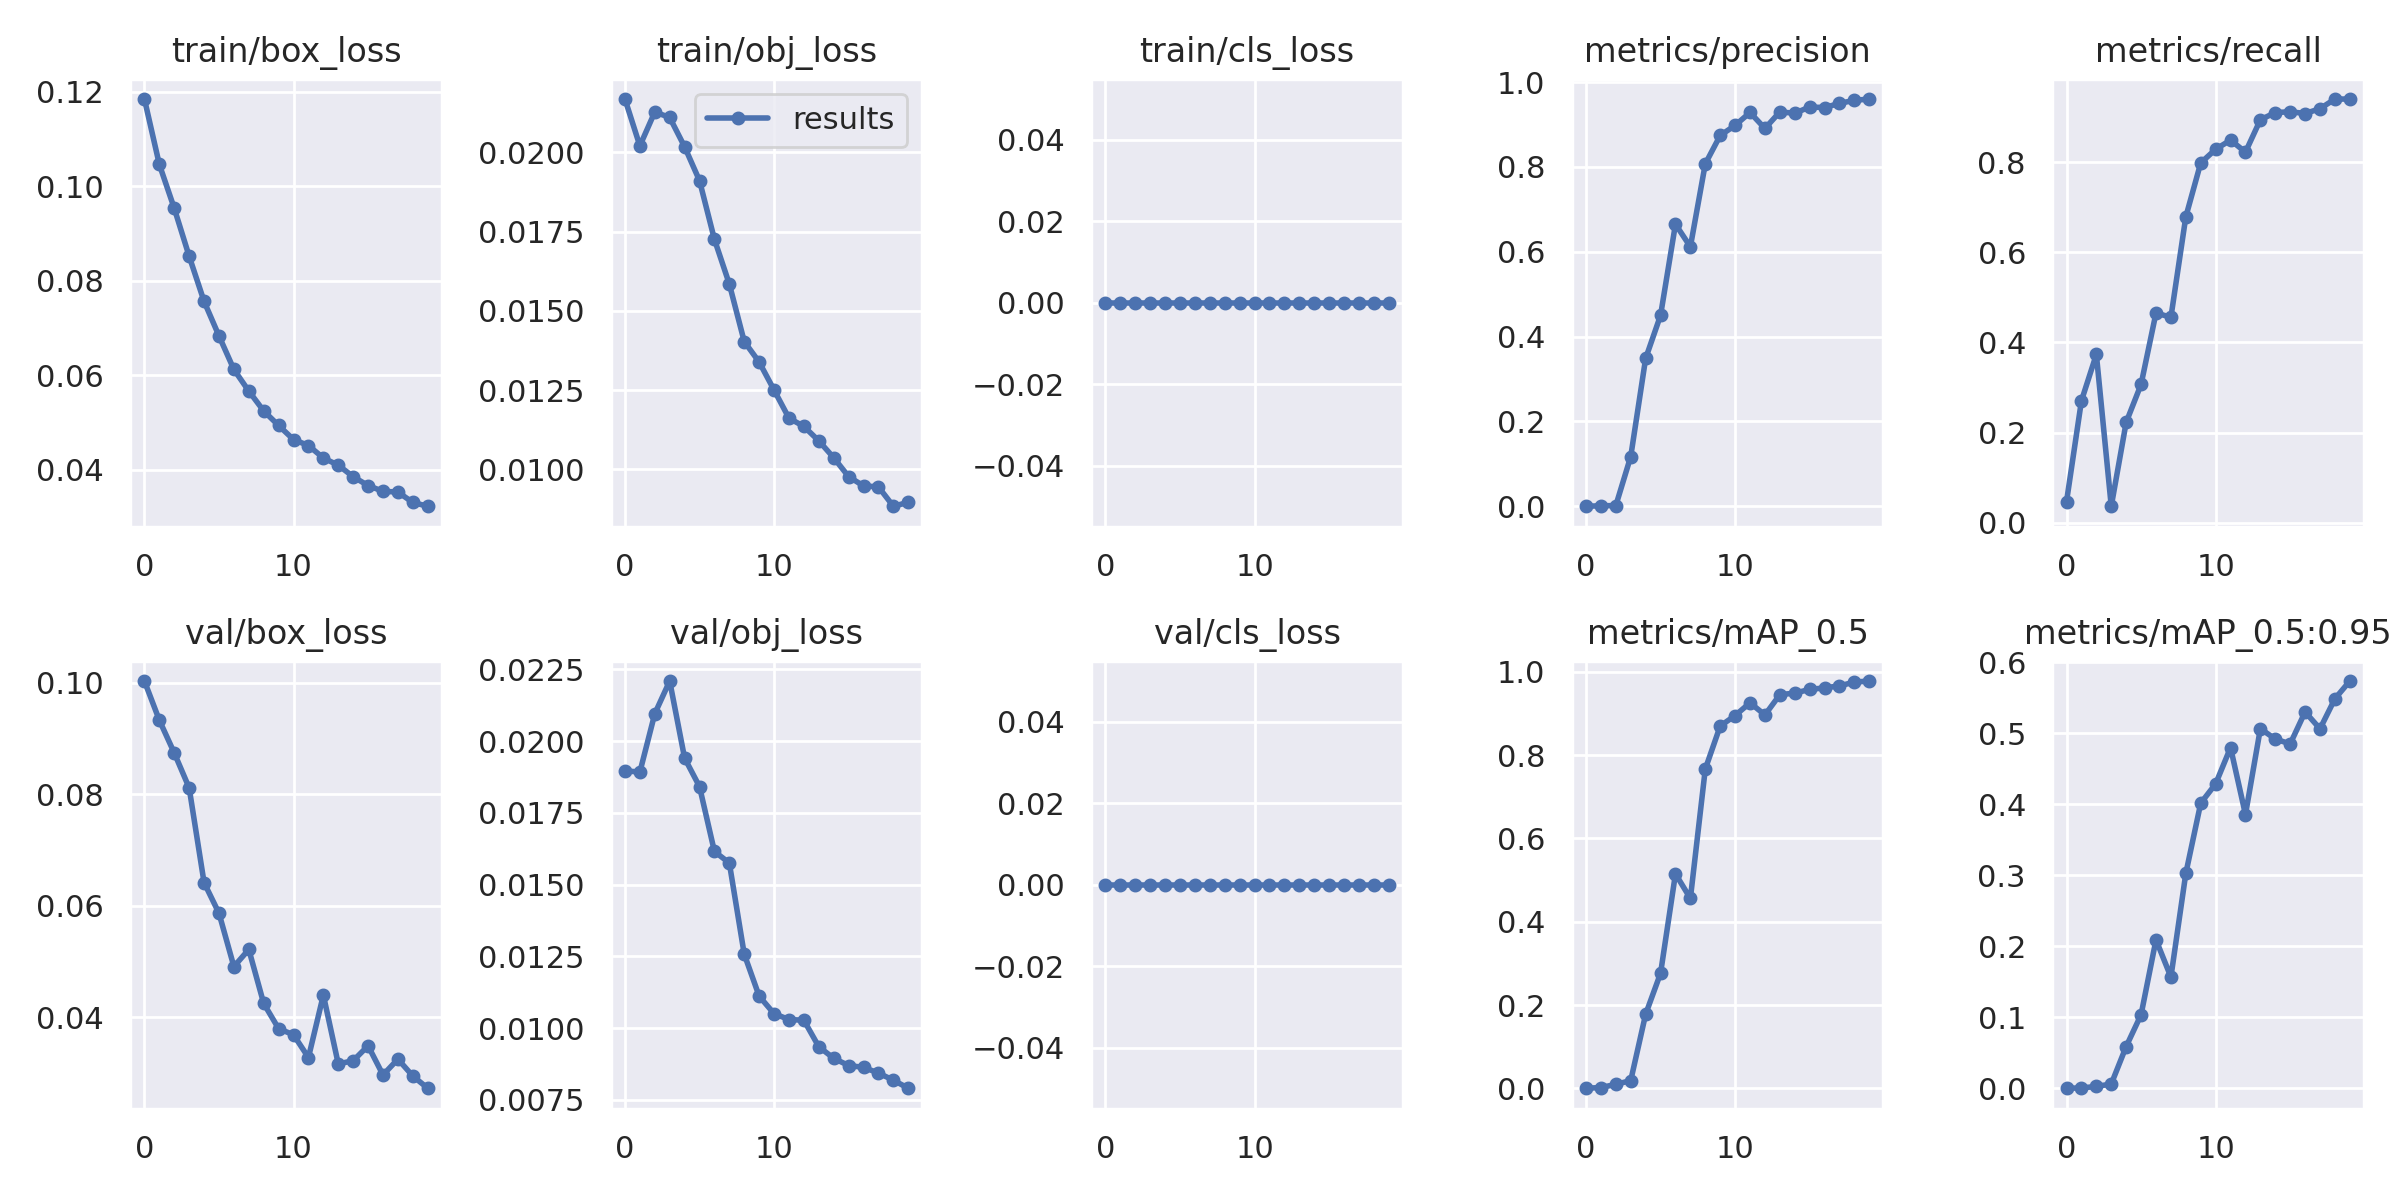

In [44]:
display.Image(filename='runs/train/exp5/results.png', width=1000)

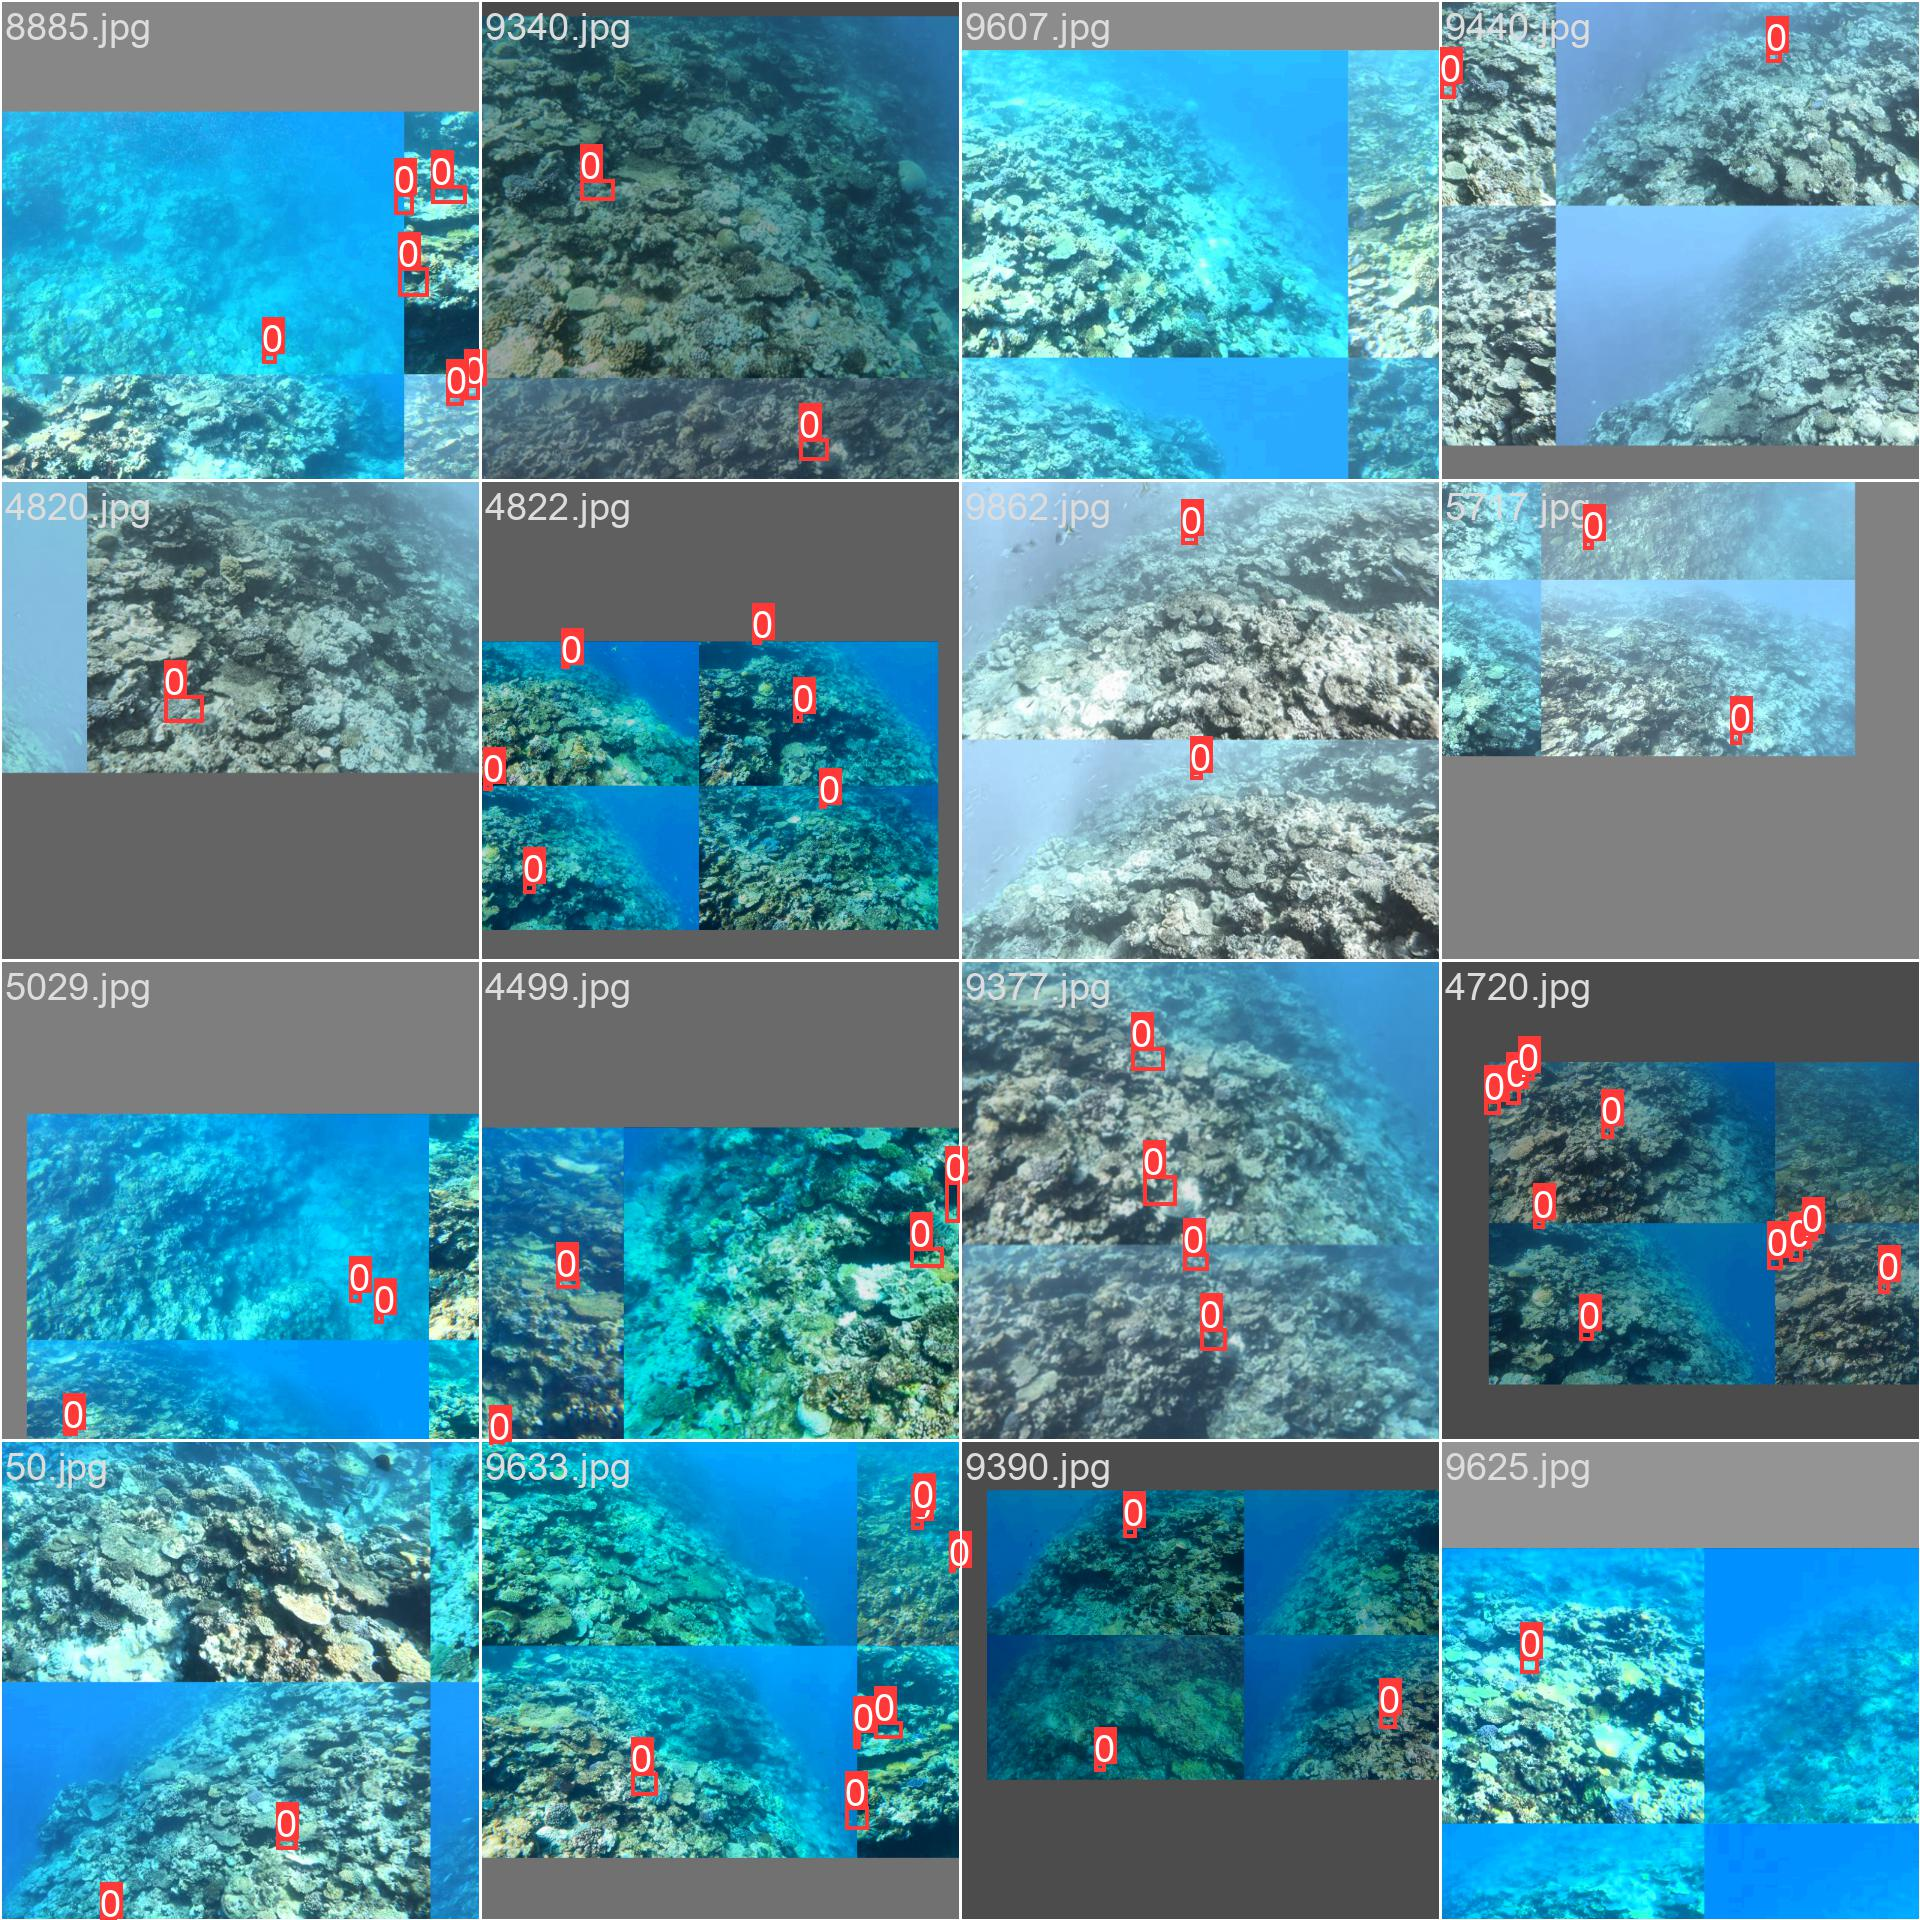

In [57]:
display.Image(filename='runs/train/exp5/train_batch0.jpg', width=700)

Сравнение разметок на валидационных данных с результатами детекции также показывают высокую точность полученной модели

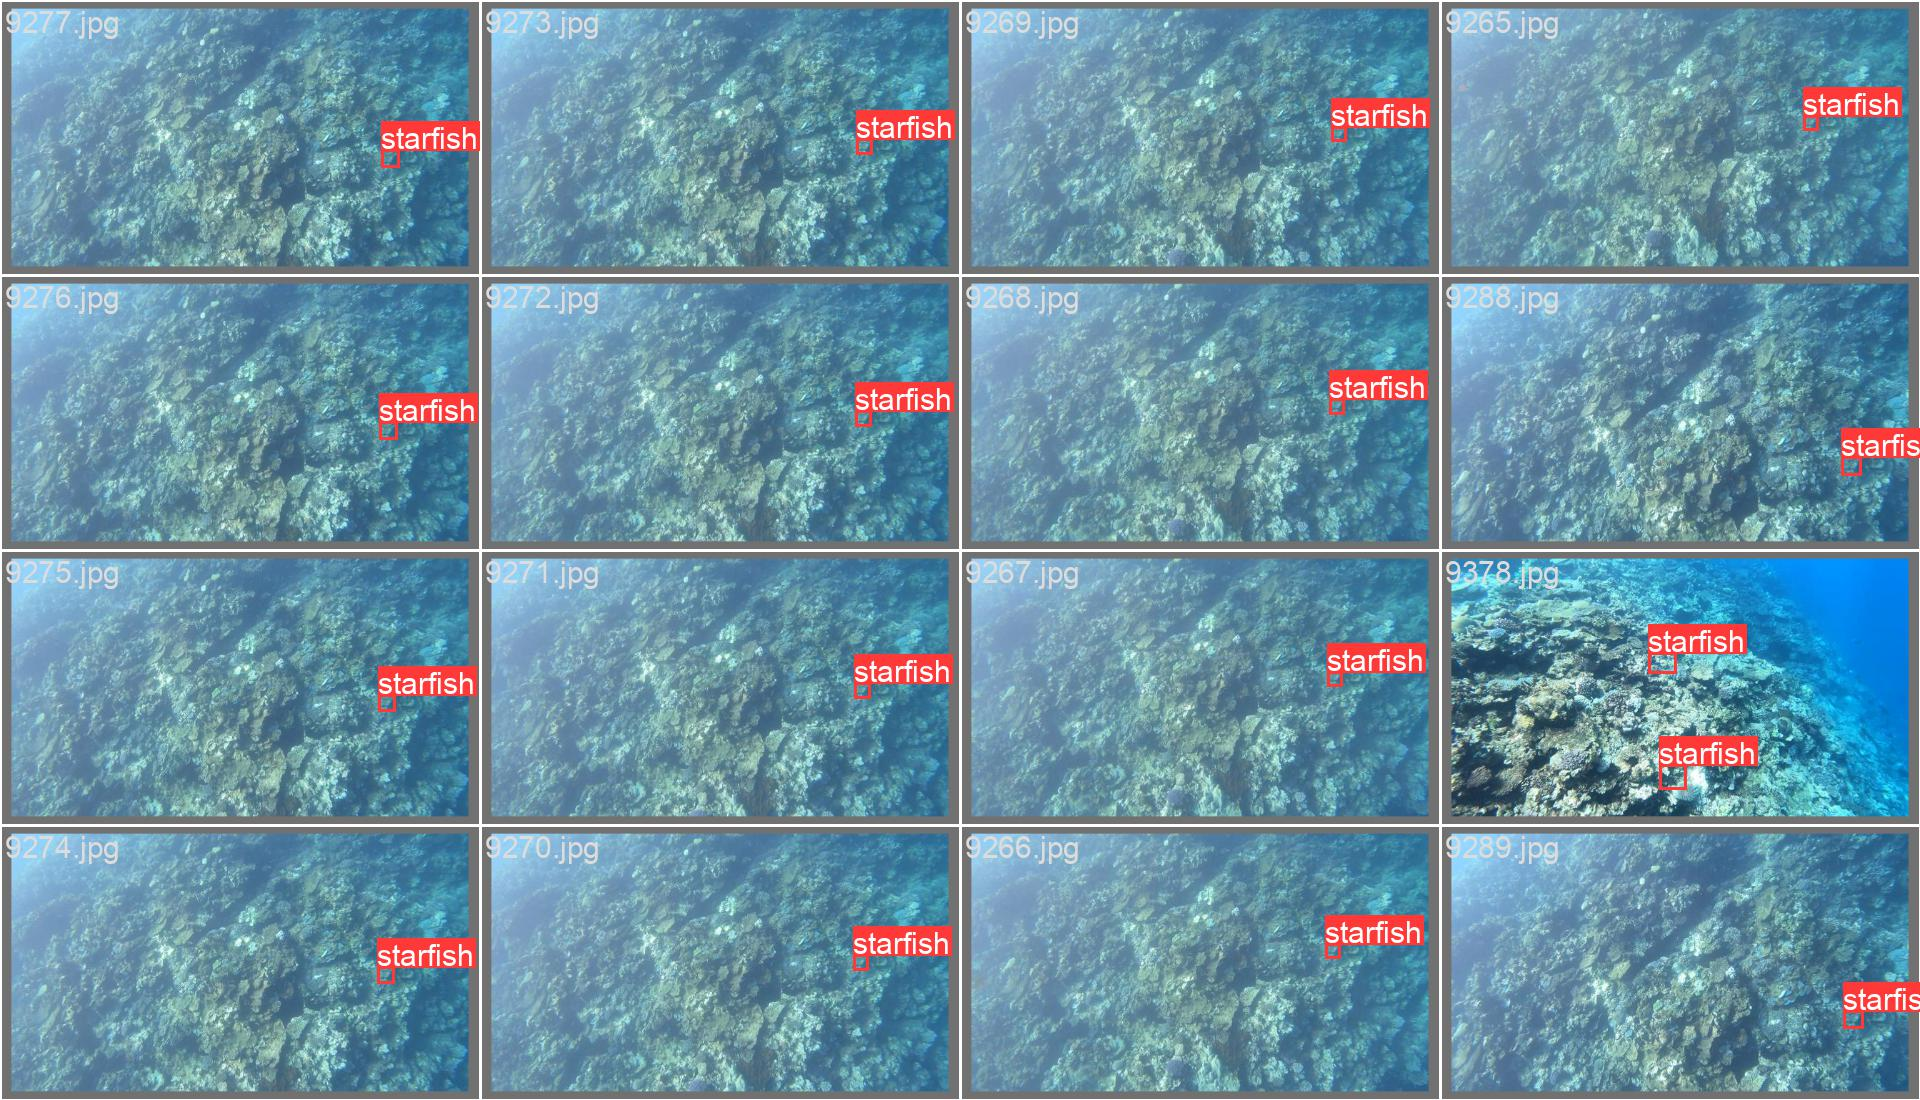

In [60]:
display.Image(filename='runs/train/exp5/val_batch2_labels.jpg', width=1000)

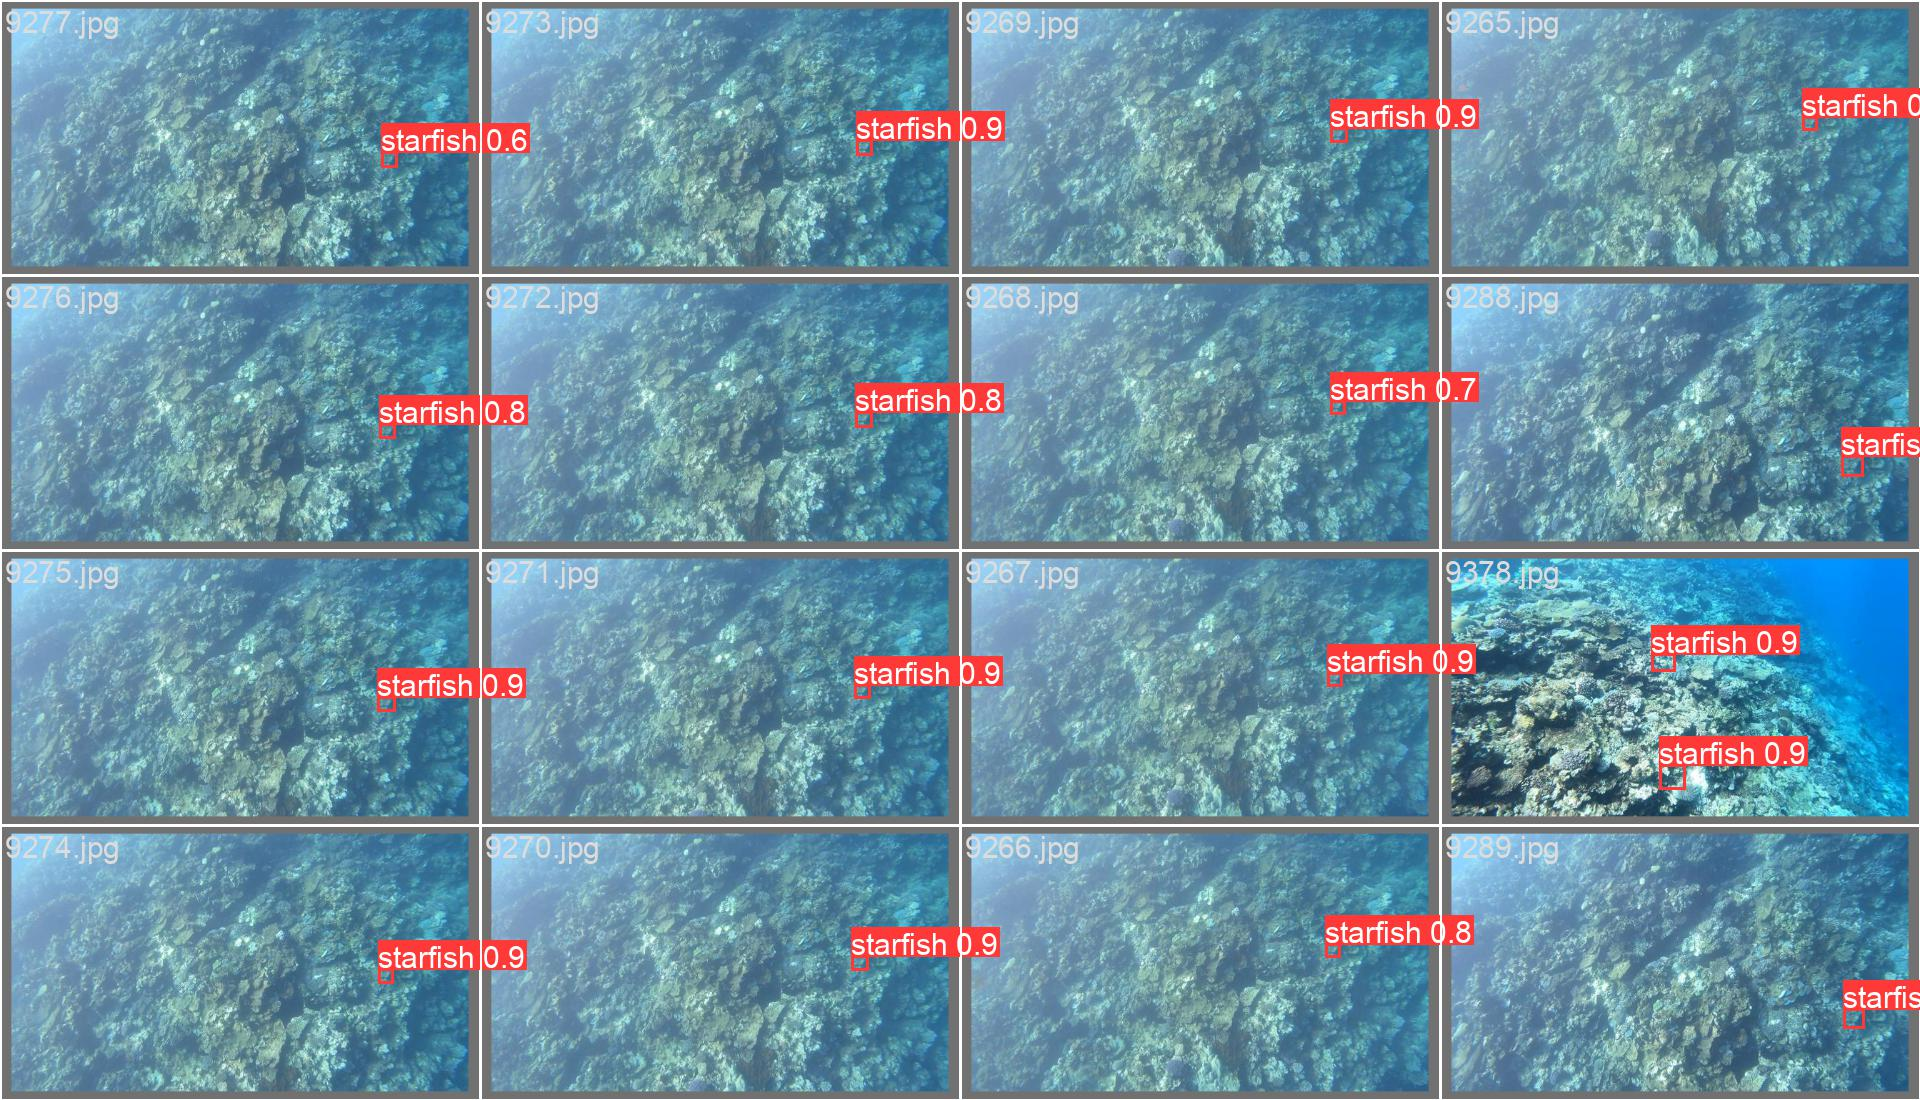

In [64]:
display.Image(filename='runs/train/exp5/val_batch2_pred.jpg', width=1000)

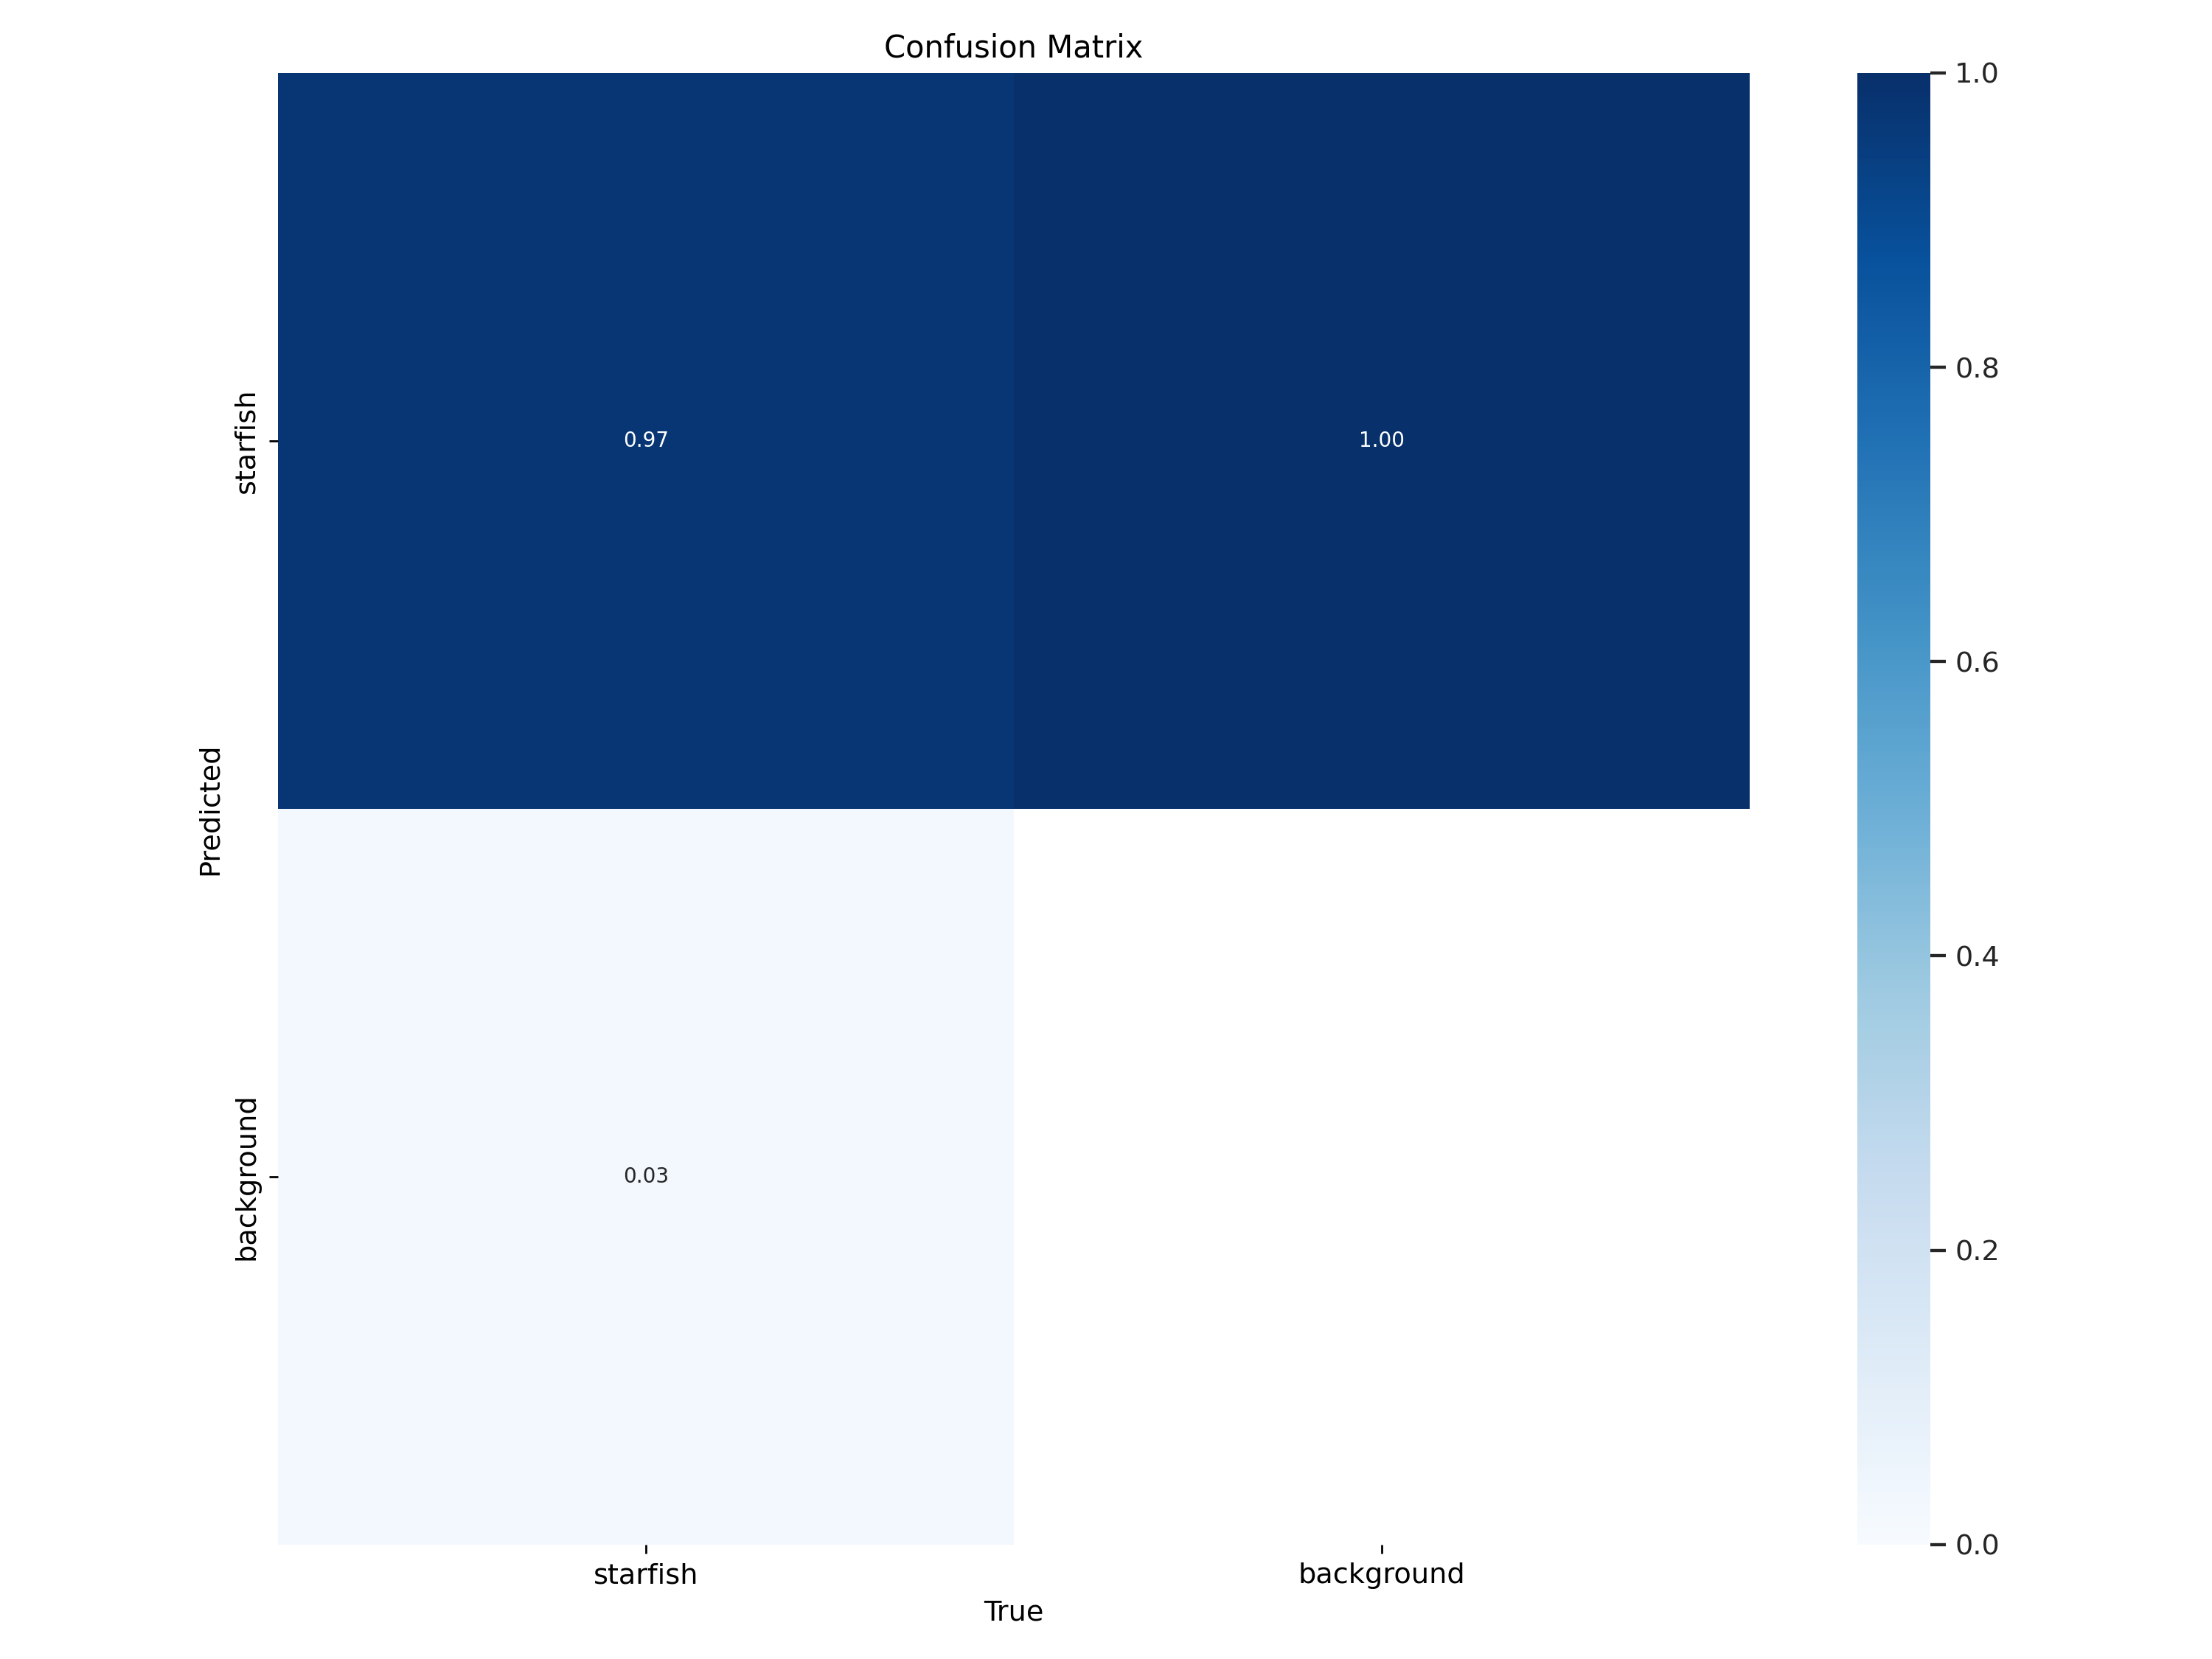

In [48]:
display.Image(filename='runs/train/exp5/confusion_matrix.png', width=700)

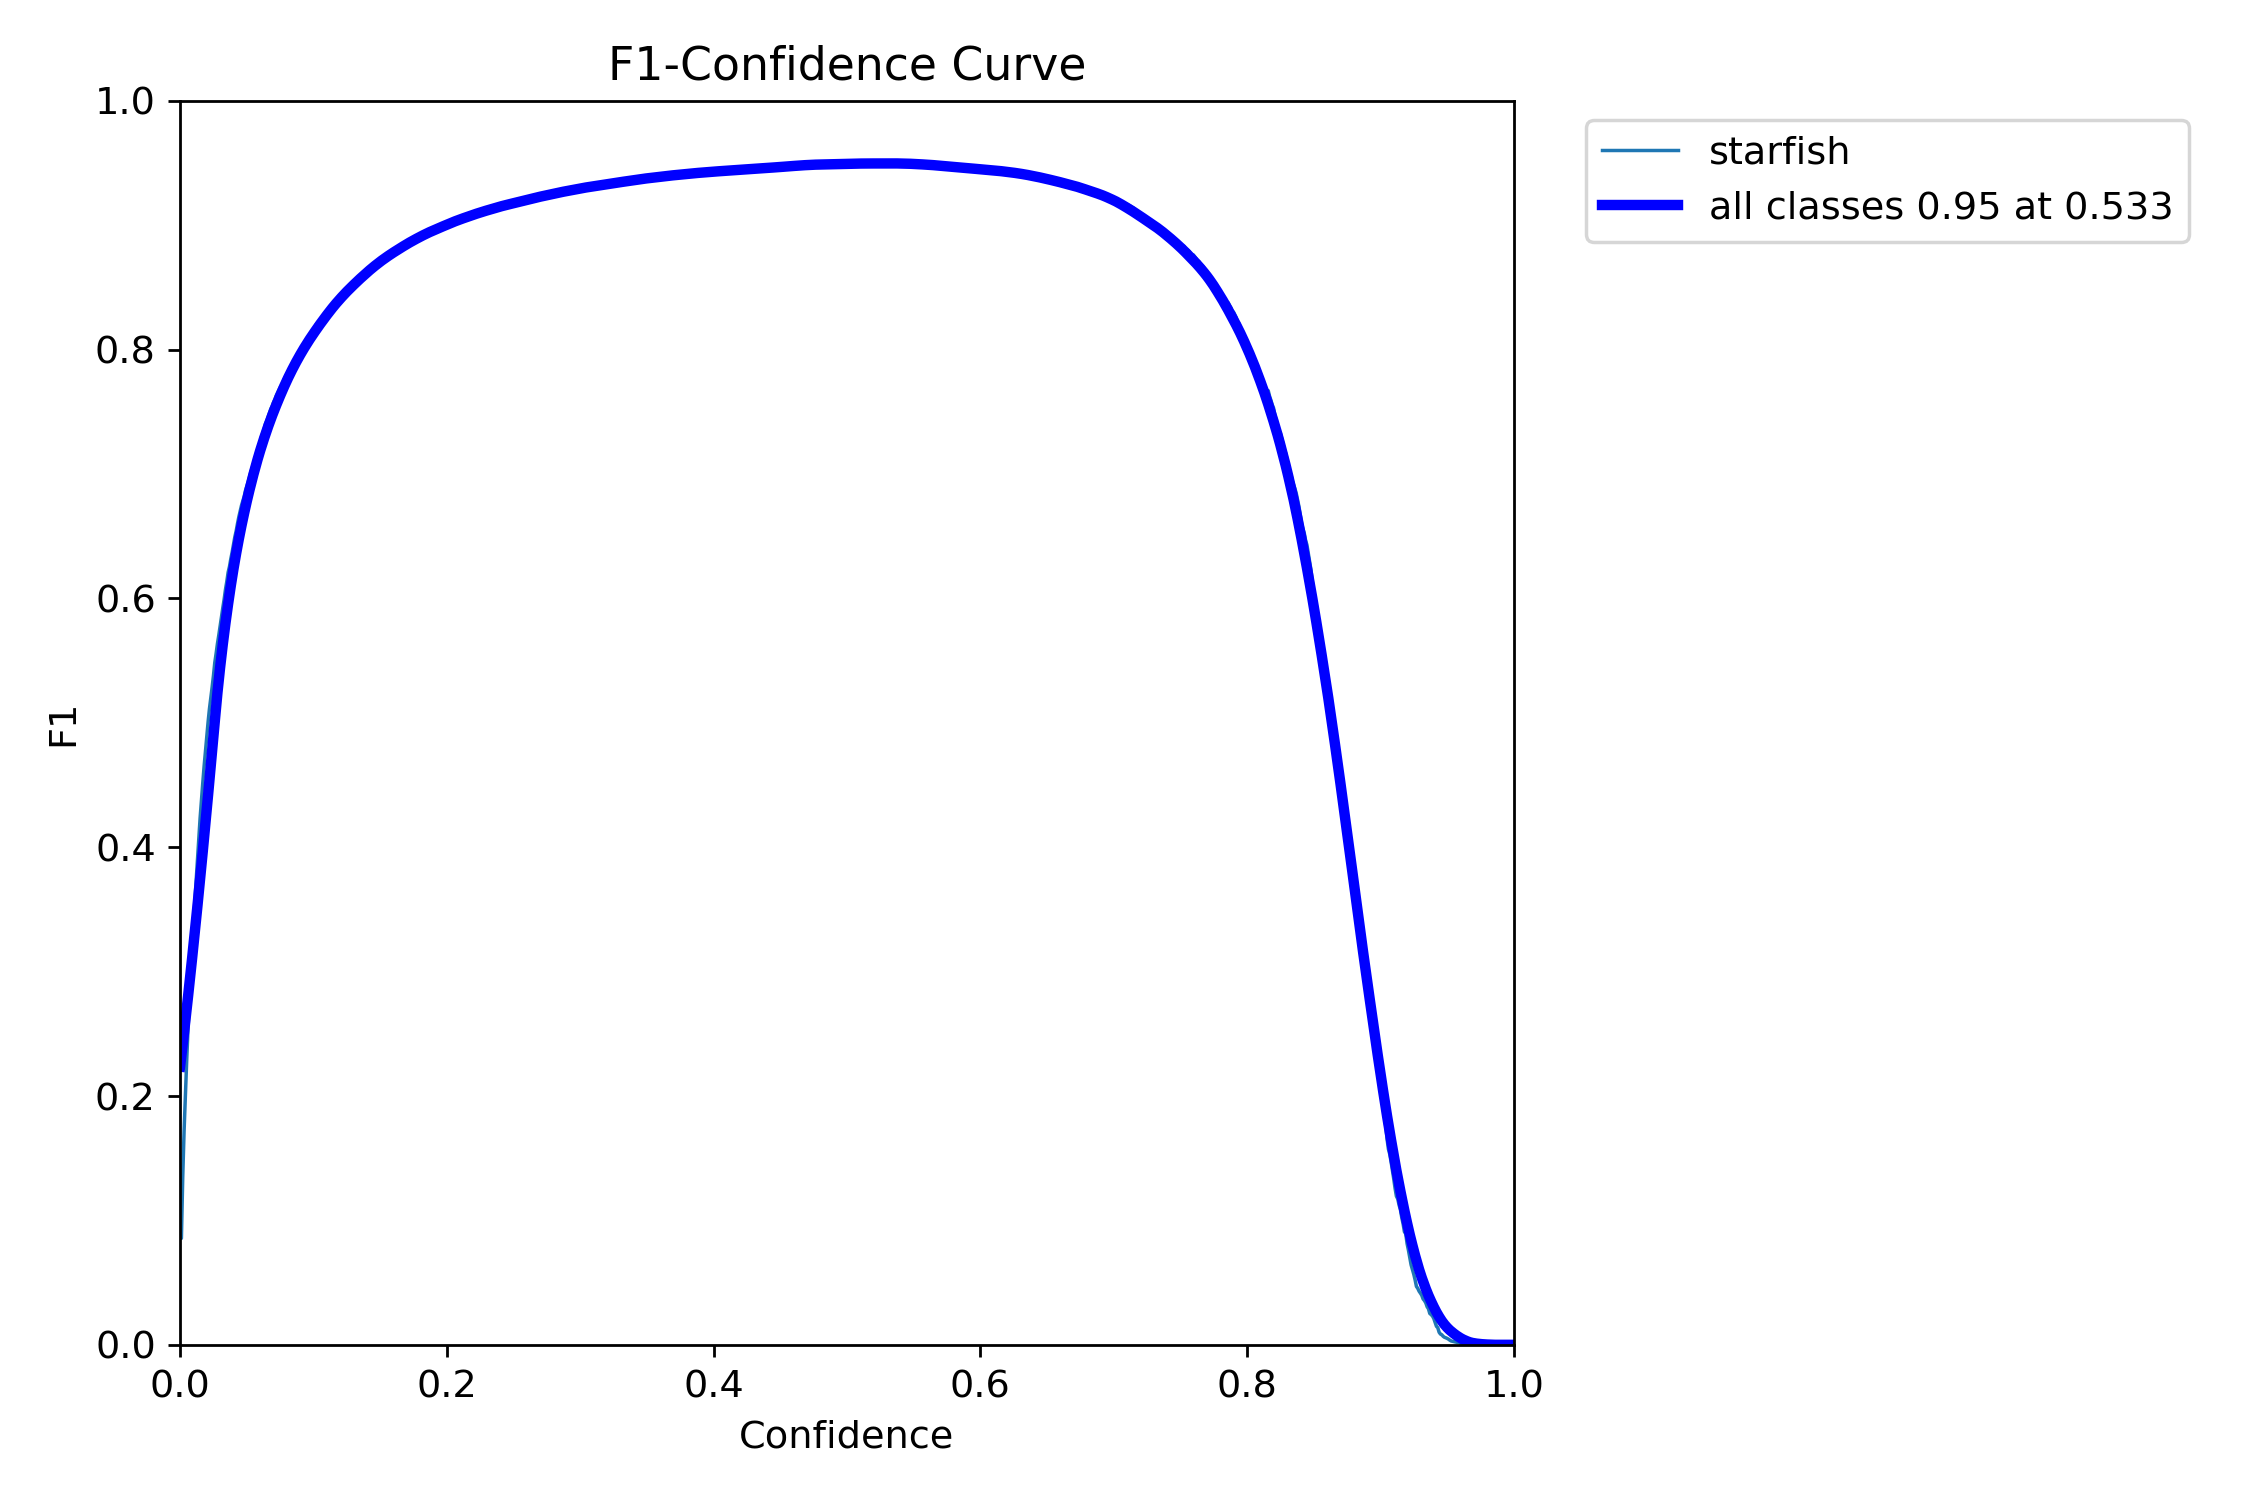

In [49]:
display.Image(filename='runs/train/exp5/F1_curve.png', width=700)

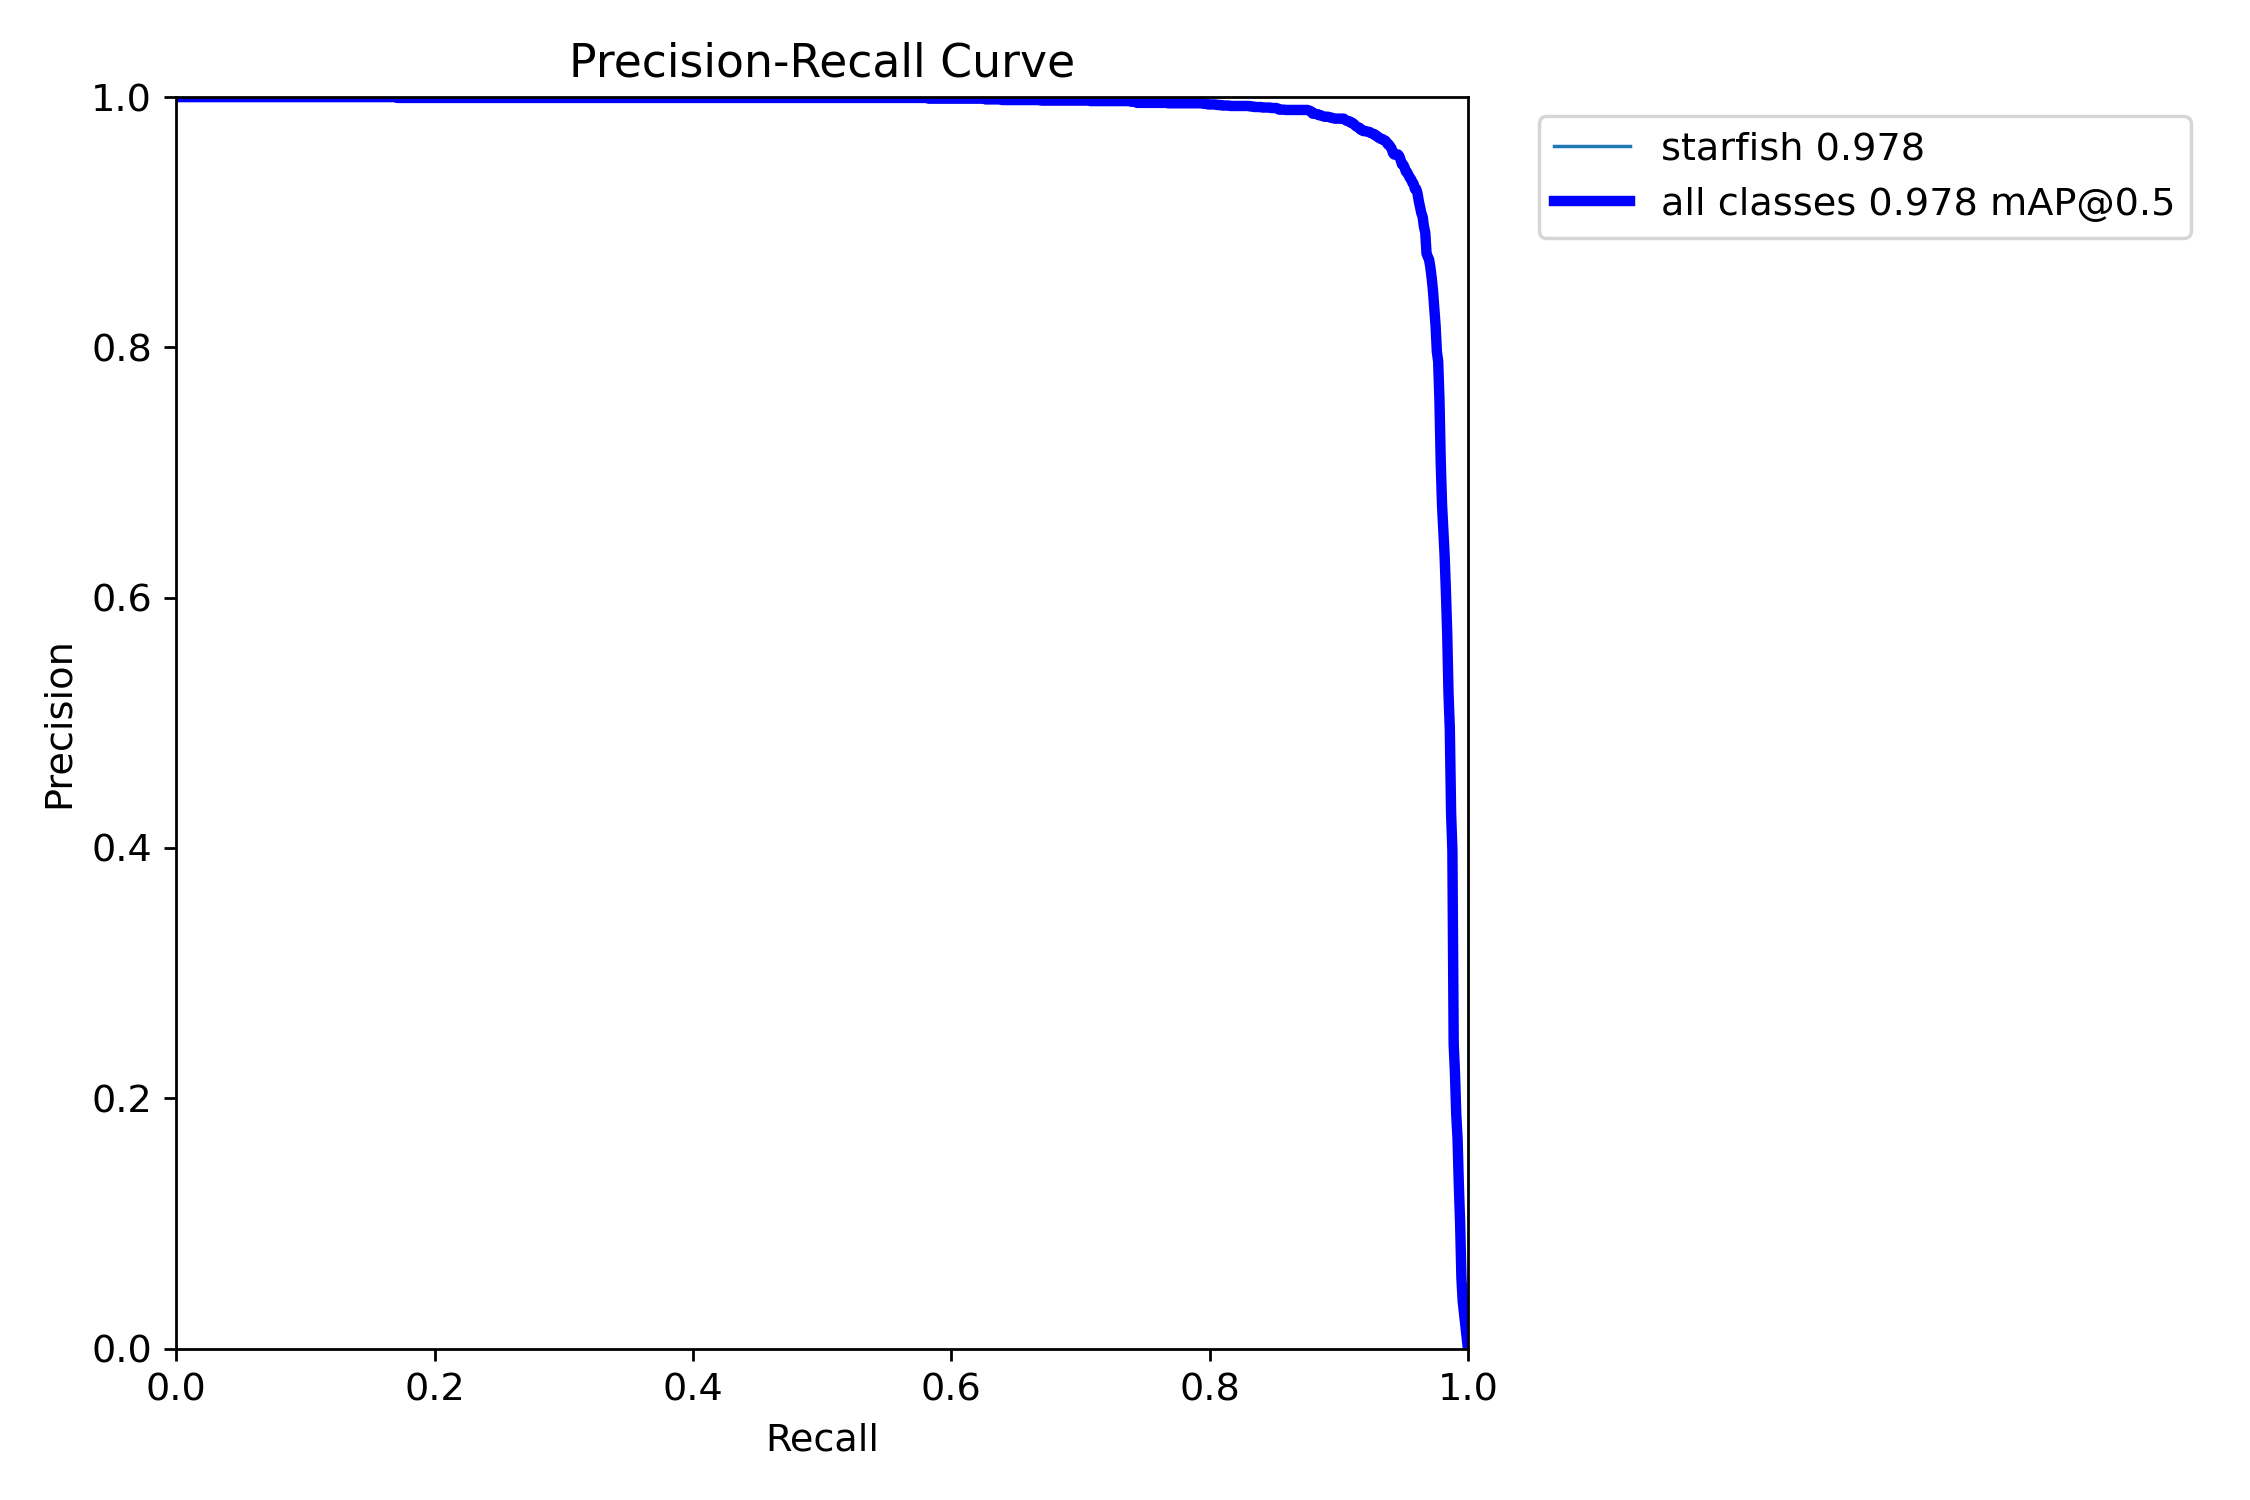

In [50]:
display.Image(filename='runs/train/exp5/PR_curve.png', width=700)

### Вывод
В ходе обучения была получана модель, хорошо справляющаяся с задачей детекции терновых венцов, что видно как по метрикам (presision/recall), так и по примеру ее работы с вылидационными данными. Единственная странность наблюдается на матрице спутывания, наверное она плохо работает, когда класс всего один.